# Classificação de imagem
Neste projeto, classificará imagens do [conjunto de dados CIFAR-10] (https://www.cs.toronto.edu/~kriz/cifar.html). O conjunto de dados consiste em aviões, cães, gatos e outros objetos. Você irá pré-processar as imagens e, em seguida, treinar uma rede neural convolucional em todas as amostras. As imagens precisam ser normalizadas e os rótulos precisam ser codificados com um só hot. Você conseguirá aplicar o que aprendeu e crie uma camada convolutiva, máximo de pool, abandono e camadas totalmente conectadas. No final, você verá as previsões da rede neural sobre as imagens de amostra.



## Pegar os dados

Execute a seguinte célula para baixar o [conjunto de dados CIFAR-10 para python] (https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).


In [16]:
import os
os.chdir('C:\\Users\\jochagas\\Documents\\DLND-Image-Classification-master\\DLND-Image-Classification-master')
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile


cifar10_dataset_folder_path = 'cifar-10-batches-py'

floyd_cifar10_location = '/cifar/cifar-10-python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explorar os dados

O conjunto de dados é dividido em lotes para evitar que sua máquina fique sem memória. O conjunto de dados CIFAR-10 consiste em 5 lotes, denominados `data_batch_1`,` data_batch_2`, etc. Cada lote contém os rótulos e as imagens que são uma das seguintes

O dataset está em inglês, então deixarei as caracteristicas com seus nomes originais

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck


Compreender um conjunto de dados é parte de fazer previsões. Jogue com a célula de código abaixo alterando o `batch_id` e` sample_id`. O `batch_id` é o id para um lote (1-5). O `sample_id` é o id para um par de etiquetas e imagens no lote.

Pergunte a si mesmo "Quais são todos os rótulos possíveis?", "Qual é o intervalo de valores para os dados da imagem?", "Os rótulos estão em ordem ou aleatórios?". Respostas a perguntas como estas irão ajudá-lo a pré-processar os dados e acabar com melhores previsões.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 10:
Image - Min Value: 24 Max Value: 130
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


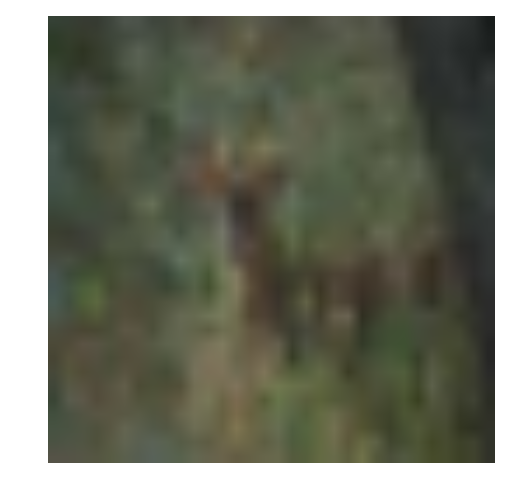

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explorando o dataset
batch_id = 1
sample_id = 10
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Funções de preprocessamento
### Normalização

Na célula abaixo, implemente a função `normalize` para tirar dados da imagem,` x` e devolvê-la como uma matriz Numpy normalizada. Os valores devem estar no intervalo de 0 a 1, inclusive. O objeto de retorno deve ter a mesma forma que `x`

In [18]:
def normalize(x):
    """
    NNormalizando a lista de exemplos de imagens entre 0 e 1
    : x: Lista de dadis de imagem.  Shape  da imagem (32, 32, 3)
    : return: Array de Numpy normalizado
    """
    x_min = 0
    x_max = 255
    
    o_min = 0
    o_max = 1
    
    arr_x = np.array(x)
    arr_x = (arr_x - x_min) * (o_max - o_min)/(x_max - x_min) + o_min
    
    
    
    
    
    return arr_x

tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Assim como a célula de código anterior, você estará implementando uma função para pré-processamento. Desta vez, você implementará a função `one_hot_encode`. A entrada, `x`, é uma lista de etiquetas. Implemente a função para retornar a lista de rótulos como uma matriz Numpy codificada com One-Hot. Os valores possíveis para os rótulos são de 0 a 9. A função de codificação one-hot deve retornar a mesma codificação para cada valor entre cada chamada para `one_hot_encode`. Certifique-se de salvar o mapa de codificações fora da função.

Dica: não reinventar a roda.

In [19]:
# importando o LabelBinarizer para facilicar no enconding das features
from sklearn.preprocessing import LabelBinarizer

In [20]:

def one_hot_encode(x):
    """
    Codificando os labels
    """ 
    # Tamanho do vetor é dez porque vai de 0 a 9
    tam = 10

    encoder = LabelBinarizer().fit(np.arange(tam, dtype=np.float32))

    return encoder.transform(x)
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomizar os dados
Como você viu ao explorar os dados acima, a ordem das amostras é randomizada. Não faz mal aleatorizar novamente, mas você não precisa para este conjunto de dados.

## Preprocessar todos os dados e salva-los
Rodando o codigo abaixo irá preprocessar todo o conjunto de dados CIFAR-10 e salva-los em um arquivo. O Código abaixo também utiliza 10% dos dados de treinamento para validação.


In [21]:
# Preprocessamento dos dados de treinamento, teste e validação
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point

Este é o primeiro Checkpoint. Se o notebook for restardado, todos os dados preprocessados já estão salvos no disco

In [22]:
import pickle
import problem_unittests as tests
import helper

# Carregar dados de validação preprocessados anteriormente
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Construir a rede neural

Para a rede neural, você irá construir cada camada em uma função. A maioria do código que você viu esteve fora das funções. Para testar seu código mais completamente, nós exigimos que você coloque cada camada em uma função. Isso nos permite dar-lhe melhores comentários e testar erros simples usando nossos testes unitários antes de enviar seu projeto.

> ** Nota: ** Se você achar difícil dedicar tempo suficiente para este curso todas as semanas, fornecemos um pequeno atalho para esta parte do projeto. Nos próximos problemas, você terá a opção de usar classes das [Camadas TensorFlow] (https://www.tensorflow.org/api_docs/python/tf/layers) ou [TensorFlow Layers (contrib)] ( https://www.tensorflow.org/api_guides/python/contrib.layers) pacotes para construir cada camada, exceto as camadas que você constrói na seção "Camada convolutiva e camada máxima de agrupamento". TF Layers é semelhante à abstração de Keras e TFLearn para camadas, por isso é fácil de capturar.

> No entanto, se você quiser tirar o máximo proveito deste curso, tente resolver todos os problemas sem usar qualquer coisa dos pacotes do TF Layers. Você ** pode ** ainda usar aulas de outros pacotes que tenham o mesmo nome que você encontra em TF Layers! Por exemplo, em vez de usar a versão TF Layers da classe `conv2d`, [tf.layers.conv2d] (https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), você gostaria de use a versão TF Neural Network do `conv2d`, [tf.nn.conv2d] (https://www.tensorflow.org/api_docs/python/tf/nn/conv2d).!

Bora lá.

### Entrada
A rede neural precisa ler os dados da imagem, os rótulos codificados de uma só vez e a probabilidade de abandono. Implementar as seguintes funções
* Implementar `neural_net_image_input`
 * Retornar um [marcador de posição TF] (https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Defina a forma usando `image_shape` com o tamanho do lote configurado para` None`.
 * Nomeie o marcador de posição TensorFlow "x" usando o parâmetro TenseFlow `name` no [Marcador de posição TF] (https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implementar `neural_net_label_input`
 * Retornar um [marcador de posição TF] (https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Defina o formato usando `n_classes` com o tamanho do lote configurado para` None`.
 * Nomeie o marcador de posição TensorFlow "y" usando o parâmetro TensorFlow `name` no [Marcador de posição TF] (https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implementar `neural_net_keep_prob_input`
 * Retorna um [marcador de posição TF] (https://www.tensorflow.org/api_docs/python/tf/placeholder) para a suspensão de retenção de probabilidade.
 * Nomeie o marcador de posição TensorFlow "keep_prob" usando o parâmetro TenseFlow `name` no [marcador de espaço TF] (https://www.tensorflow.org/api_docs/python/tf/placeholder).

Esses nomes serão usados ​​no final do projeto para carregar o modelo salvo.

Nota: `None` para formas em TensorFlow permite um tamanho dinâmico.

In [23]:
# importando tensorflow
import tensorflow as tf

In [24]:
# Funções

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape=[None,image_shape[0], image_shape[1], image_shape[2]], name='x' )


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.int32, shape=[None, n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    
    # Obrigatório o nome keep_prob
    return tf.placeholder(tf.float32, name='keep_prob')

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution e Max Pooling Layer
As camadas de convolução têm muito sucesso com as imagens. Para esta célula de código, você deve implementar a função `conv2d_maxpool` para aplicar a convolução e o agrupamento máximo:
* Crie o peso e o viés usando `conv_ksize`,` conv_num_outputs` e a forma de `x_tensor`.
* Aplicar uma convolução para `x_tensor` usando peso e` conv_strides`.
* Recomendamos que você use o mesmo preenchimento, mas você pode usar qualquer preenchimento.
* Adicionar parcial
* Adicionar uma ativação não linear da convolução.
* Aplicar Max Pooling usando `pool_ksize` e` pool_strides`.
* Recomendamos que você use o mesmo preenchimento, mas você pode usar qualquer preenchimento.

** Nota: ** Você ** não pode ** usar [TensorFlow Layers] (https://www.tensorflow.org/api_docs/python/tf/layers) ou [TensorFlow Layers (contrib)] (https: / /www.tensorflow.org/api_guides/python/contrib.layers) para ** esta camada **, mas você ainda pode usar a [Rede Neural] da TensorFlow (https://www.tensorflow.org/api_docs/python/tf/ nn) pacote. Você ainda pode usar a opção de atalho para todas as ** outras camadas **.

In [25]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Aplicar convolução max_pooling > x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Numero de output para camada de convolução
    :param conv_ksize: kernal size 2-D Tupla para a camada de convolução
    :param conv_strides: Stride 2-D Tupla para camada de convolução
    :param pool_ksize: kernal size 2-D Tupla para pool
    :param pool_strides: Stride 2-D Tupla para pool
    : return: tensor - Tensor representeando a aplicação de max_pooling para x_tensor
    """
    altura  = int(x_tensor.shape[1])
    largura = int(x_tensor.shape[2])
    profund = int(x_tensor.shape[3])
    
    f_altura = conv_ksize[0]
    f_largura = conv_ksize[1]
    
    
    
    passo = [1, 
             conv_strides[0], 
             conv_strides[1], 
             1]
    
    agr_ks = [1, 
              pool_ksize[0], 
              pool_ksize[1], 
              1]
    
    agr_str = [1, 
               pool_strides[0], 
               pool_strides[1], 
               1]
    
    filtro_medidas = tf.Variable(tf.truncated_normal(shape=[f_altura, 
                                                            f_largura,
                                                            profund,
                                                            conv_num_outputs],
                                                     stddev=0.05))
    
    filtro_bias = tf.Variable(tf.zeros(conv_num_outputs))
    padding = 'SAME'
    conv = tf.add(tf.nn.conv2d(x_tensor,
                               filtro_medidas,
                               strides = passo, 
                               padding=padding), 
                  filtro_bias)
    
    conv = tf.nn.relu(conv)
    
    conv = tf.nn.max_pool(conv, 
                          ksize = agr_ks,
                          strides = agr_str,
                          padding = padding)
    
    return conv

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implementar a função `flatten` para alterar a dimensão de` x_tensor` de um tensor 4-D para um tensor 2-D. A saída deve ser a forma (* Tamanho do lote *, * Tamanho da imagem achatada *). Opção de atalho: você pode usar classes das [Camadas TensorFlow] (https://www.tensorflow.org/api_docs/python/tf/layers) ou [TensorFlow Layers (contrib)] (https://www.tensorflow.org) /api_guides/python/contrib.layers) pacotes para esta camada. Para mais de um desafio, use apenas outros pacotes TensorFlow.

In [26]:
def flatten(x_tensor):
    """
    Flatten x_tensor para (Batch Size, Flattened Image Size)
    : x_tensor: A tensor de tamanha (Batch Size, ...), onde ... é a dimensão da imagem (alt x larg x prof).
    : return: A tensor de tamanho (Batch Size, Flattened Image Size).
    """
    altura  = int(x_tensor.shape[1])
    largura = int(x_tensor.shape[2])
    profund = int(x_tensor.shape[3])
    
    f_layer = altura*largura*profund
    
    # Remodelar tensor de 3d para 2d
    return tf.reshape(x_tensor,[-1, f_layer])

tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implemente a função `fully_conn` para aplicar uma camada totalmente conectada a` x_tensor` com a forma (* Tamanho do lote *, * num_outputs *). Opção de atalho: você pode usar classes das [Camadas TensorFlow] (https://www.tensorflow.org/api_docs/python/tf/layers) ou [TensorFlow Layers (contrib)] (https://www.tensorflow.org) /api_guides/python/contrib.layers) pacotes para esta camada. Para mais de um desafio, use apenas outros pacotes TensorFlow.

In [27]:
def fully_conn(x_tensor, num_outputs):
    """
    Aplicar camada totalmente conectada (fully connected layer) ao x_tensor usando pesos(weights) e viés (bias)
    : x_tensor: Um tensor de 2-D onde a primeira dimensão é o tamanho do batch.
    : num_outputs: Numero de output que o novo tensor deve ter
    : return: Um tensor 2-D onde a segunda dimensão é o numero de output
    """
    
    largura = int(x_tensor.shape[1])
    
    
    layer_weigths = tf.Variable(tf.truncated_normal(shape=[largura, num_outputs], stddev=0.05))
    
    # Iniciar bias com 0 e a quantidade de saidas
    layer_bias = tf.Variable(tf.zeros(num_outputs))
    
    # Camada de saída
    layer_out = tf.nn.relu(tf.add(tf.matmul(x_tensor, layer_weigths), layer_bias))
    return layer_out
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

Implemente a função `output` para aplicar uma camada totalmente conectada a` x_tensor` com a forma (* Tamanho do lote *, * num_outputs *). Opção de atalho: você pode usar classes das [Camadas TensorFlow] (https://www.tensorflow.org/api_docs/python/tf/layers) ou [TensorFlow Layers (contrib)] (https://www.tensorflow.org) /api_guides/python/contrib.layers) pacotes para esta camada. Para mais de um desafio, use apenas outros pacotes TensorFlow.

** Nota: ** Ativação, softmax ou entropia cruzada deve ** não ** ser aplicado a isso.

In [28]:
def output(x_tensor, num_outputs):
    """
    Aplicar uma camada de output ao x_tensor utilizando pesos(weights) e viés (bias).
    : x_tensor: Um tensor 2-D onde a primeira dimensão é o tamanho do batch.
    : num_outputs: Numero de output que o novo tensor deve ter.
    : return: Um tensor 2-D onde a segunda dimensão é a quantidade de output que o tensor deve ter.
    """
     # Pegar largura dos inputs
    largura = int(x_tensor.shape[1])
    # Inicializar pesos da camada totalmente conectada
    layer_weigths = tf.Variable(tf.truncated_normal(shape=[largura, num_outputs], stddev=0.05))
    # Inicializar viés com zero da camada totalmente conectada
    layer_bias = tf.Variable(tf.zeros(num_outputs))
    # Definir camada de saída
    layer_out = tf.add(tf.matmul(x_tensor, layer_weigths), layer_bias)
    return layer_out

tests.test_output(output)

Tests Passed


### Create Convolutional Model

Implementar a função `conv_net` para criar um modelo de rede neural convolucional. A função ocupa um lote de imagens, `x` e logs de saídas. Use as camadas que você criou acima para criar este modelo:

* Aplicar 1, 2 ou 3 camadas Convolution e Max Pool
* Aplicar uma camada Flatten
* Aplicar 1, 2 ou 3 camadas totalmente conectadas
* Aplicar uma camada de saída
* Retornar a saída
* Aplicar [Saída do TensorFlow] (https://www.tensorflow.org/api_docs/python/tf/nn/dropout) para uma ou mais camadas no modelo usando `keep_prob`.

In [29]:
def conv_net(x, keep_prob):
    """
    Criar modelo de rede neural convulacional
    : x: tensor placeholder contendo os dados da imagem
    : keep_prob: tensor placeholder contendo  o keep prob dropout
    : return: Tensor que representa os logits
    """
    # Definir parametros para primeira camada convulacional
    p_conv_saida = 32
    p_conv_tam   = [4,4]
    p_conv_passo = [1,1]
    p_agr_tam    = [3,3]
    p_agr_passo  = [2,2]
    
    
    # Definir parametros para secgunda camada convulacional
    
    s_conv_saida = 16
    s_conv_tam    = [4,4]
    s_conv_passo  = [1,1]
    s_agr_tam     = [3,3]
    s_agr_passo   = [2,2]

    
    # parametros para camada totalmente conectada
    layer1 = 128
    layer2 = 64
    qt_output = 10
    
    # Primeira camada
    first_conv_layer = conv2d_maxpool(x, 
                                      s_conv_saida, 
                                      p_conv_tam, 
                                      p_conv_passo, 
                                      p_agr_tam, 
                                      p_agr_passo)
    # Segunda camada
    second_conv_layer = conv2d_maxpool(first_conv_layer, 
                                      s_conv_saida, 
                                      s_conv_tam, 
                                      s_conv_passo, 
                                      s_agr_tam, 
                                      s_agr_passo)
    
    
    
    
    f_layer = flatten(second_conv_layer)
    
    # Primeira camada totalmente conectada
    f_layer_1 = fully_conn(f_layer, layer1)
    # Segunda camada totalmente conectada
    f_layer_2 = fully_conn(f_layer_1, layer2)
    dropout  =  tf.nn.dropout(f_layer_2, keep_prob)
    # Saída
    outpuut = output(dropout, qt_output)
    return outpuut


##############################
## Construir rede neural ##
##############################

# Resetar o grafo (Remover pesos, viéses, ect)
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Modelo
logits = conv_net(x, keep_prob)

# Carregando o logit
logits = tf.identity(logits, name='logits')

# Perda e otimizador
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Precisão
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Treinar Rede Neural
### Otimização individual
Implementar a função `train_neural_network` para fazer uma única otimização. A otimização deve usar o "otimizador" para otimizar em `session` com um` feed_dict` do seguinte:
* `x` para entrada de imagem
* `y` para etiquetas
* `keep_prob` para manter a probabilidade de abandono escolar

Esta função será chamada para cada lote, então `tf.global_variables_initializer ()` já foi chamado.

Nota: Nada precisa ser devolvido. Esta função apenas otimiza a rede neural.

In [30]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Otimizar sessão com imagens em labels em batch
    : session: Sessão atual do tensorflow
    : optimizer: Função de otimização do tensorflow
    : keep_probability: keep probability
    : feature_batch: Batch de dados da imagens - Numpy
    : label_batch: Batch de label das imagens - Numpy
    """
    fd_dict = {x: feature_batch, y: label_batch, keep_prob: keep_probability}
    session.run(optimizer, feed_dict=fd_dict)

tests.test_train_nn(train_neural_network)

Tests Passed


### Mostrar estatísticas
Implementar a função `print_stats` para imprimir perda e precisão de validação. Use as variáveis ​​globais `valid_features` e` valid_labels` para calcular a precisão da validação. Use uma probabilidade de manter "1.0" para calcular a perda e a precisão de validação.

In [31]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Printar informação do perda e acurácia
    : session: Sessão atual do Tensorflow
    : feature_batch: Batch de imagens
    : label_batch: Batch de labels
    : cost: Custo da função
    : accuracy: Precisão do Modelo
    """
    train_loss = session.run(cost,
                             feed_dict={
                             x: feature_batch, 
                             y: label_batch,
                             keep_prob: 1.0})
    
    train_accuracy = session.run(accuracy,
                                 feed_dict={
                                 x: feature_batch, 
                                 y: label_batch,
                                 keep_prob: 1.0})
    
    
    validation_loss = session.run(cost,
                                  feed_dict={
                                  x: valid_features,
                                  y: valid_labels,
                                  keep_prob: 1.0})
    
    validation_accuracy = session.run(accuracy,
                                      feed_dict={
                                      x: valid_features, 
                                      y: valid_labels,
                                      keep_prob: 1.0})
    print('Treinando Perca/Precisão: {:0.4f}/{:0.4f} | Validação Perca/Precisão {:0.4f}/{:0.4f}'.format(train_loss, train_accuracy, validation_loss, validation_accuracy))

### Hyperparameters
Sintonize os seguintes parâmetros:
* Defina `epochs` para o número de iterações até a rede parar de aprender ou começar a superar
* Defina `batch_size` para o número mais alto para o qual sua máquina possui memória. A maioria das pessoas os configura em tamanhos comuns de memória:
 * 64
 * 128
 * 256
 * ...
* Defina `keep_probability` para a probabilidade de manter um nó usando dropout

In [32]:

epochs = 50
batch_size = 2048
keep_probability = 0.55

### Treinar em um único lote CIFAR-10
Em vez de treinar a rede neural em todos os lotes de dados CIFAR-10, vamos usar um único lote. Isso deve economizar tempo enquanto você itera no modelo para obter uma melhor precisão. Uma vez que a precisão de validação final é de 50% ou superior, execute o modelo em todos os dados na próxima seção.

In [33]:
print('Treinando os dados de um único batch...')
with tf.Session() as sess:
    # Inicializando variáveis
    sess.run(tf.global_variables_initializer())
    
    # Treinando 1 batch
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.2916/0.1510 | Validation Loss/Accuracy 2.2930/0.1216
Epoch  2, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.2599/0.1498 | Validation Loss/Accuracy 2.2616/0.1358
Epoch  3, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.1948/0.2277 | Validation Loss/Accuracy 2.1919/0.2208
Epoch  4, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.1063/0.2314 | Validation Loss/Accuracy 2.1020/0.2228
Epoch  5, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.0611/0.2488 | Validation Loss/Accuracy 2.0515/0.2464
Epoch  6, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.0297/0.2550 | Validation Loss/Accuracy 2.0203/0.2558
Epoch  7, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.0062/0.2587 | Validation Loss/Accuracy 1.9931/0.2680
Epoch  8, CIFAR-10 Batch 1:  Training Loss/Accuracy: 1.9863/0.2723 | Validation Loss/Accuracy 1.9825/0.2644
Epoch  9, CIFAR-10 Batch 1:  Training Loss/Accuracy: 1.9560/0.2834 | Validation Loss/Accuracy

### Treinar completamente o modelo
Agora que você obteve uma boa precisão com um único lote CIFAR-10, experimente com todos os cinco lotes.

In [35]:
save_model_path = './image_classification'

print('Treinando...')
with tf.Session() as sess:
    # Inicializando as variáveis
    sess.run(tf.global_variables_initializer())
    
    # Treinar 1 batch
    for epoch in range(epochs):
        # Iterar em todos os batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Treinando...
Epoch  1, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.2969/0.1225 | Validation Loss/Accuracy 2.2977/0.1064
Epoch  1, CIFAR-10 Batch 2:  Training Loss/Accuracy: 2.2844/0.1312 | Validation Loss/Accuracy 2.2839/0.1270
Epoch  1, CIFAR-10 Batch 3:  Training Loss/Accuracy: 2.2433/0.2166 | Validation Loss/Accuracy 2.2457/0.1876
Epoch  1, CIFAR-10 Batch 4:  Training Loss/Accuracy: 2.1521/0.2512 | Validation Loss/Accuracy 2.1698/0.2248
Epoch  1, CIFAR-10 Batch 5:  Training Loss/Accuracy: 2.0632/0.2562 | Validation Loss/Accuracy 2.0915/0.2336
Epoch  2, CIFAR-10 Batch 1:  Training Loss/Accuracy: 2.0457/0.2748 | Validation Loss/Accuracy 2.0397/0.2506
Epoch  2, CIFAR-10 Batch 2:  Training Loss/Accuracy: 1.9850/0.2871 | Validation Loss/Accuracy 1.9946/0.2884
Epoch  2, CIFAR-10 Batch 3:  Training Loss/Accuracy: 1.9458/0.2797 | Validation Loss/Accuracy 1.9471/0.2910
Epoch  2, CIFAR-10 Batch 4:  Training Loss/Accuracy: 1.8965/0.3267 | Validation Loss/Accuracy 1.9081/0.3100
Epoch  2, CIFAR

# Checkpoint
O modelo foi salvo no disco.

## Testar Modelo
Teste seu modelo contra o conjunto de dados de teste. Esta será a sua precisão final. Você deve ter uma precisão superior a 50%. Se você não fizer isso, continue ajustando a arquitetura do modelo e os parâmetros.

INFO:tensorflow:Restoring parameters from ./image_classification
Teste de precisão: 0.6092998147010803



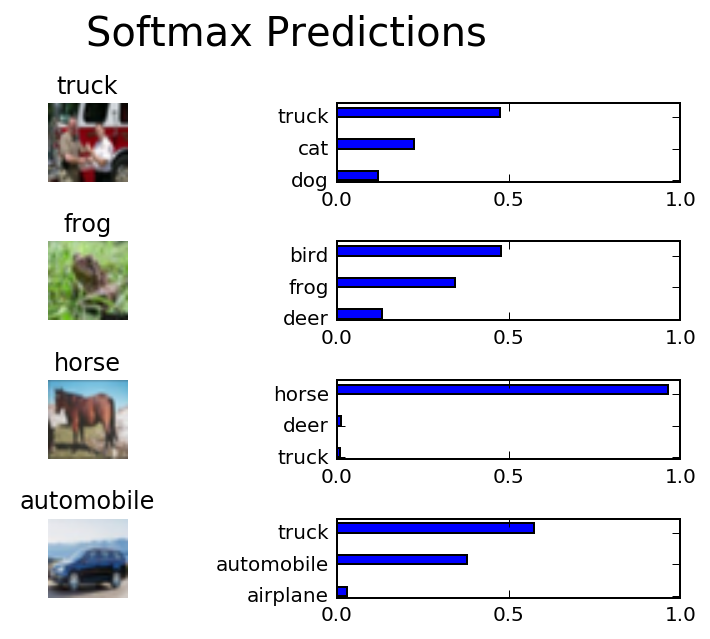

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Se o batch não estiver pronto, setar o batch
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Testar modelo salvo com o testset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Carregar modelo
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Pegar tensores do modelo carregado
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Pegar acurácias para batchs com limitação de memória.
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Teste de precisão: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Printar exemplos aleatórios
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Porque 50-80% de Precisão?
Você pode estar se perguntando por que você não consegue obter uma precisão maior. Primeiro, primeiro, 50% não é ruim para uma CNN simples. A adivinhação pura obteria 10% de precisão. No entanto, você pode notar que as pessoas estão obtendo pontuações [bem acima de 80%] (http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). Isso porque não ensinamos a todos a saber sobre redes neurais. Ainda precisamos cobrir mais algumas técnicas.

## Enviando este projeto
Ao enviar este projeto, certifique-se de executar todas as células antes de salvar o notebook. Salve o arquivo do caderno como "dlnd_image_classification.ipynb" e guarde-o como um arquivo HTML em "Arquivo" -> "Download como". Inclua os arquivos "helper.py" e "problem_unittests.py" em sua submissão.